In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from la_forge.core import Core
import scipy.linalg as sl
from statsmodels.stats.correlation_tools import cov_nearest
from enterprise.signals.utils import powerlaw

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils
from defiant import pair_covariance
from defiant.extra import mdc1_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
psrs, inj_params = mdc1_utils.get_mdc1_psrs()
pta = mdc1_utils.create_MDC1_PTA(psrs)

In [48]:
OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


In [49]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(params=inj_params,pair_covariance=True,narrowband=False)
fgw = OS_obj.freqs

_,_,_,_,tr_Sk,tr_Sks = OS_obj.compute_PFOS(params=inj_params,pair_covariance=False,narrowband=False)
fgw = OS_obj.freqs

100%|██████████| 10/10 [00:00<00:00, 1042.87it/s]


In [52]:
xi_range = np.linspace(0.01,np.pi,1000)
hd_mod = utils.orf_xi(xi_range,'hd')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)

In [53]:
problem_freq = 4
sig_ab = sigk[problem_freq]
ORF = OS_obj.orf_design_matrix
data = rhok[problem_freq]
cov = Ck[problem_freq]


xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],
                                                     Ck[problem_freq],
                                                     bins=15,orf='hd')

# non-PC solution
tr_A2 = tr_Sk[problem_freq]
tr_A2s = tr_Sks[problem_freq]

print(np.log10(np.linalg.cond(cov)))

7.288042387491587


/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/utils.py:367: RuntimeWarning: invalid value encountered in sqrt
  sigavg[i] = np.abs(bin_orf)*np.sqrt(s2)


In [54]:
print(tr_A2,'\n',tr_A2s)

[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


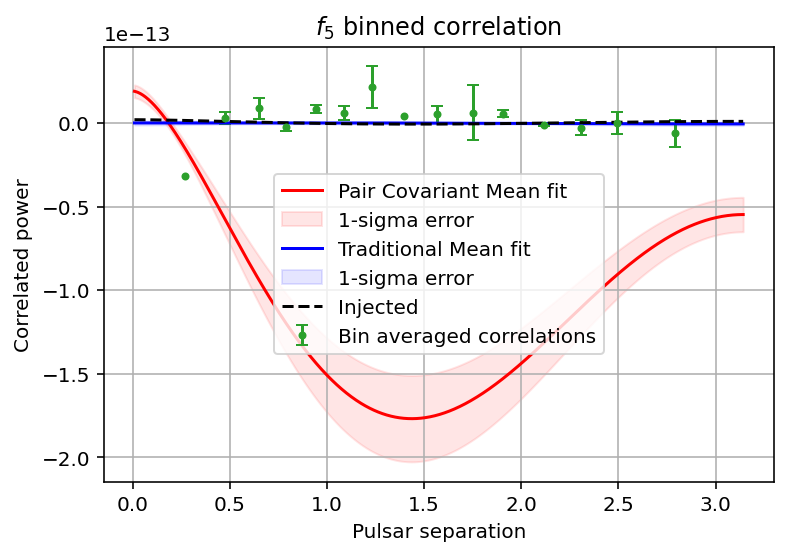

In [55]:
plt.title(f'$f_{problem_freq+1}$ binned correlation')

plt.errorbar(xiBin,rhoBin,sigBin,fmt='.C2',capsize=3,label='Bin averaged correlations')

mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,Sk[problem_freq],Sks[problem_freq],['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Pair Covariant Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')

mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,tr_A2,tr_A2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-b',label='Traditional Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='b',alpha=0.1,label='1-sigma error')


plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

### A New way to fit

In [56]:
nearest = cov_nearest(cov,threshold=1e-10)
cho_fac = sl.cho_factor(nearest)

fisher_inv = ORF.T @ sl.cho_solve(cho_fac,ORF)

dirtymap = ORF.T @ sl.cho_solve(cho_fac,data)

A2 = fisher_inv@dirtymap
A2s = fisher_inv
print(A2,'\n',A2s)

print(tr_A2,'\n',tr_A2s)

[ 1.20161456e+64 -1.45951655e+64 -1.28449501e+65] 
 [[1.62324549e+39 1.57053606e+39 4.05993817e+38]
 [1.57053606e+39 4.26068856e+39 5.46906808e+39]
 [4.05993817e+38 5.46906808e+39 2.03984114e+40]]
[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


In [57]:
fisher_inv = ORF.T @ np.linalg.solve(cov,ORF,)

dirtymap = ORF.T @ np.linalg.solve(cov,data)

A2 = fisher_inv@dirtymap
A2s = fisher_inv
print(A2,'\n',A2s)

print(tr_A2,'\n',tr_A2s)

[4.12873729e+43 1.24588321e+44 9.19274067e+43] 
 [[2.42338704e+28 5.40905038e+28 5.35381614e+28]
 [5.40905038e+28 1.93989234e+29 1.19882814e+29]
 [5.35381614e+28 1.19882814e+29 1.20834222e+29]]
[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


In [58]:
cinv = np.linalg.pinv(cov,rcond=1e-14)

fisher_inv = ORF.T @ cinv @ ORF

dirtymap = ORF.T @ cinv @ data

A2 = fisher_inv@dirtymap
A2s = fisher_inv
print(A2,'\n',A2s)

print(tr_A2,'\n',tr_A2s)

[4.12873729e+43 1.24588321e+44 9.19274067e+43] 
 [[2.42338704e+28 5.40905038e+28 5.35381614e+28]
 [5.40905038e+28 1.93989234e+29 1.19882814e+29]
 [5.35381614e+28 1.19882814e+29 1.20834222e+29]]
[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


In [59]:
np.allclose(cov,nearest)

True

In [60]:
X,Z = OS_obj._compute_XZ(inj_params)
phi = pta[0]['gw'].get_phi(inj_params)
sk = phi[2*problem_freq]

_,_,normabk = OS_obj._compute_rhok_sigk(X,Z,phi,narrowband=False)

phi1 = np.zeros( shape=(len(OS_obj.freqs)) )  
phi1[problem_freq] = 1
phi1 = np.repeat(phi1,2)

phi2 = phi/sk


all_C = pair_covariance._factored_pair_covariance(Z,phi1,phi2,OS_obj._orf_matrix[0],
                                                  normabk[problem_freq],True,300)

PC elements: 199500it [00:00, 599383.29it/s]                                    


In [61]:
c0 = all_C[0] 
K = all_C[1]*sk + all_C[2]*sk**2

print(np.allclose(c0+K,cov))

True


In [62]:
ainv = np.diag(1/np.diag(c0))
I_n = np.eye(c0.shape[0]) 
Kainv = K@ainv

Ik = I_n + Kainv
print('old log10 condition number:',np.log10(np.linalg.cond(cov)))
print('new log10 condition number:',np.log10(np.linalg.cond(Ik)))

cinv = ainv - ainv @ np.linalg.pinv(Ik) @ Kainv

old log10 condition number: 7.288042387491587
new log10 condition number: 3.857282067351166


In [65]:
fisher_inv = ORF.T @ cinv @ ORF

dirtymap = ORF.T @ cinv @ data

A2 = fisher_inv@dirtymap
A2s = fisher_inv
print(A2,'\n',A2s)

print(tr_A2,'\n',tr_A2s)

[-5.00481532e+43  3.49751898e+44 -2.50197254e+45] 
 [[8.51175413e+28 8.37364064e+28 1.17383507e+29]
 [8.37364064e+28 2.22167250e+30 3.23375078e+28]
 [1.17383507e+29 3.23375078e+28 4.95093342e+30]]
[-3.43589345e-16  3.33534007e-16 -8.50404267e-17] 
 [[ 6.08198010e-30 -2.77832698e-31 -2.21031903e-31]
 [-2.77832698e-31  4.13536504e-31  2.88125002e-33]
 [-2.21031903e-31  2.88125002e-33  1.68106902e-31]]


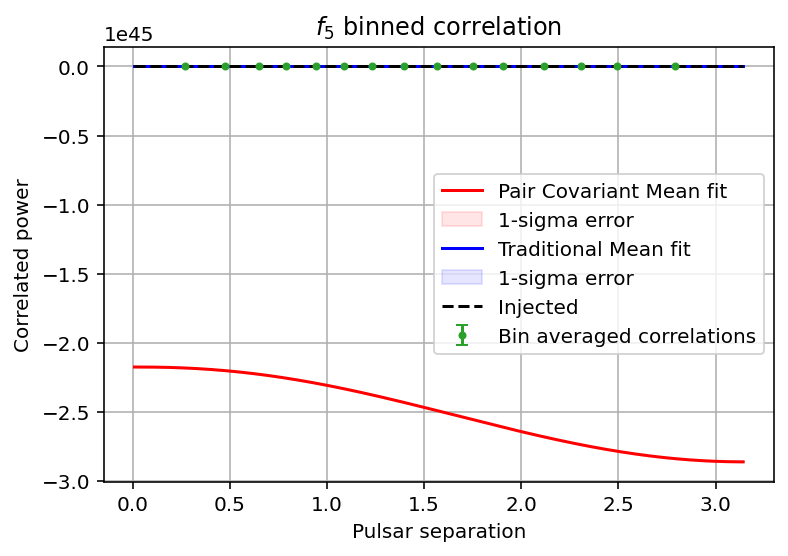

In [66]:
plt.title(f'$f_{problem_freq+1}$ binned correlation')

plt.errorbar(xiBin,rhoBin,sigBin,fmt='.C2',capsize=3,label='Bin averaged correlations')

clipped = utils.clip_covariance(A2s,1e-30)
mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,A2,clipped,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Pair Covariant Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')


mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,tr_A2,tr_A2s,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-b',label='Traditional Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='b',alpha=0.1,label='1-sigma error')


plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')


plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

## Maybe its the data thats messed up?

Lets do some simulations and see if we can find one with poor behavior

In [67]:
# Higher amplitude is more likely to cause stability issues: 1986
psrs,inj_params = mdc1_utils.create_MDC1_like_psrs(gwb_amplitude=1e-15,seed=10384,toaerr=0.1)

pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta,'gw')

a2,a2s = OS_obj.compute_OS(inj_params,return_pair_vals=False,pair_covariance=False)
print(a2/a2s)

3.103941604817552


/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/core.py:168: UserWarning: No MCMC samples were given! Set these later or supply them when computing the OS.
  warn(msg)


In [68]:
inj_a2 = 10**(2*inj_params['gw_log10_A'])

# Get matrix products
X,Z = OS_obj._compute_XZ(inj_params)
phihat = powerlaw(np.repeat(OS_obj.freqs,2), 0, 13./3.)

# Get design matrix
des = OS_obj.orf_design_matrix

# Get data
rho,sig = OS_obj._compute_rho_sig(X,Z,phihat)

# Get covariance
all_C = pair_covariance._factored_pair_covariance(Z,phihat,phihat,
                                OS_obj._orf_matrix[0],sig**2,True,300)

def fit_a2_from_est_a2(est,version='pinv'):
    S = all_C[0]
    K = est*all_C[1] + est**2*all_C[2]
    if version.lower() == 'pinv':
        # Pseudo-inverse
        cond = np.linalg.cond(S+K)
        cinv = np.linalg.pinv(S+K)
    elif version.lower() == 'woodbury':
        # Woodbury matrix inversion
        I_n = np.eye(S.shape[0])
        ainv = np.diag(1/np.diag(S))
        Kainv = K@ainv
        cond = np.linalg.cond(I_n + Kainv)
    
        cinv = ainv - ainv @ np.linalg.solve(I_n + Kainv, Kainv) 

    
    # Fisher matrix inverse
    fisher = np.linalg.pinv(des.T @ cinv @ des)

    # Dirty map
    dirtymap = des.T @ cinv @ rho

    # Get fit
    a2_fit = fisher @ dirtymap
    return a2_fit.item(), cond


_,_,_,C,a2,_ = OS_obj.compute_OS(inj_params,return_pair_vals=True,pair_covariance=True)

PC elements: 199500it [00:00, 618119.37it/s]                                    
PC elements: 199500it [00:00, 509506.87it/s]                                    


In [69]:
a2_est = 10**(2*np.linspace(-18,-14,50))
out = np.array([fit_a2_from_est_a2(a,'pinv') for a in a2_est])
a2_fit_pinv = out[:,0]
cond_pinv = out[:,1]

out = np.array([fit_a2_from_est_a2(a,'woodbury') for a in a2_est])
a2_fit_wood = out[:,0]
cond_wood = out[:,1]


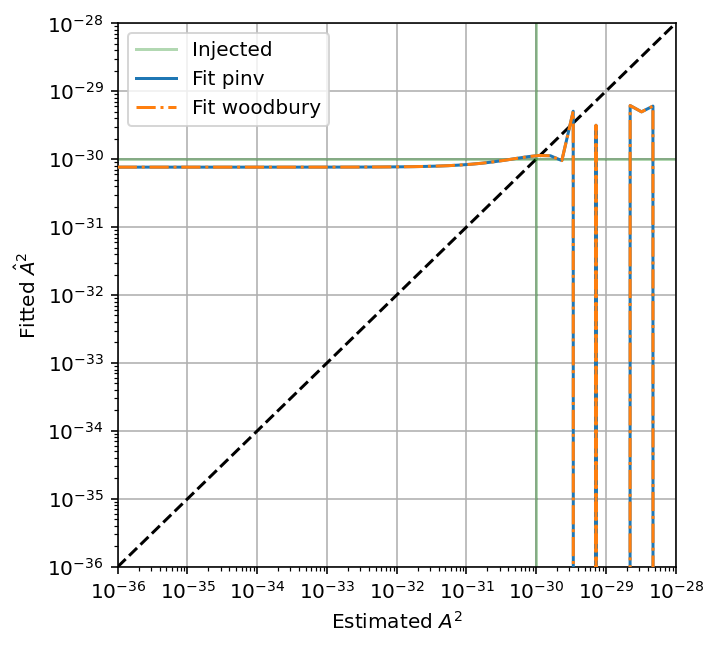

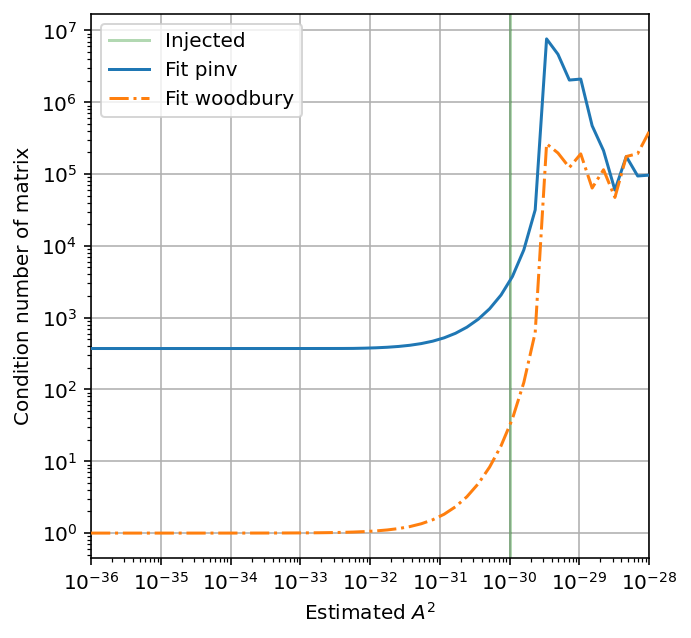

In [70]:
plt.figure(figsize=(5,5))
plt.plot(a2_est,a2_est,'--k')
plt.xlim([a2_est.min(),a2_est.max()])
plt.ylim([a2_est.min(),a2_est.max()])
plt.loglog()
plt.grid()
plt.axvline(inj_a2,color='g',label='Injected',alpha=0.3)
plt.axhline(inj_a2,color='g',alpha=0.3)
plt.xlabel('Estimated $A^2$')
plt.ylabel('Fitted $\hat{A}^2$')


plt.plot(a2_est,a2_fit_pinv,'-C0',zorder=10,label='Fit pinv')
plt.plot(a2_est,a2_fit_wood,'-.C1',zorder=10,label='Fit woodbury')

plt.legend()
plt.show()


plt.figure(figsize=(5,5))

plt.xlim([a2_est.min(),a2_est.max()])
plt.loglog()
plt.grid()
plt.axvline(inj_a2,color='g',label='Injected',alpha=0.3)
plt.xlabel('Estimated $A^2$')
plt.ylabel('Condition number of matrix')

plt.plot(a2_est,cond_pinv,'-C0',zorder=10,label='Fit pinv')
plt.plot(a2_est,cond_wood,'-.C1',zorder=10,label='Fit woodbury')

plt.legend()
plt.show()

### Lets try jiggling the rhos

In [71]:
X,Z = OS_obj._compute_XZ(inj_params)
phihat = powerlaw(np.repeat(OS_obj.freqs,2), 0, 13./3.)
rho,sig = OS_obj._compute_rho_sig(X,Z,phihat)

# Get covariance
all_C = pair_covariance._factored_pair_covariance(Z,phihat,phihat,
                                    OS_obj._orf_matrix[0],sig**2,True,300)

# Get design matrix
des = OS_obj.orf_design_matrix

def get_covariance(a2_est):
    S = all_C[0]
    K = a2_est*all_C[1] + a2_est**2*all_C[2]
    return (S,K)


def true_rhos():
    a_orf = utils.orf_xi(xi,'hd')
    new_rho = inj_a2*a_orf
    return new_rho


def random_rhos(cov):
    full_cov = cov[0] + cov[1]
    new_rho = np.random.multivariate_normal(true_rhos(),full_cov)
    return new_rho


def linear_solve(des,cov,rho):
    S,K = cov

    # Woodbury matrix inversion
    I_n = np.eye(S.shape[0])
    ainv = np.diag(1/np.diag(S))
    Kainv = K@ainv
    
    cinv = ainv - ainv @ np.linalg.solve(I_n + Kainv, Kainv) 

    # Fisher matrix inverse
    fisher_inv = np.linalg.pinv(des.T @ cinv @ des)

    # Dirty map
    dirtymap = des.T @ cinv @ rho

    # Get fit
    a2_fit = fisher_inv @ dirtymap
    return a2_fit.item(), np.sqrt(fisher_inv.item())

PC elements: 199500it [00:00, 584553.81it/s]                                    


In [72]:
a2_est = 10**(2*np.linspace(-15.5,-14.5,50))
rho_data= []
rho_true = []
rho_rand = []
rho_scaled = []

t_rho = true_rhos()
r_rho = random_rhos(get_covariance(inj_a2))


for a in a2_est:
    cov = get_covariance(a)
    
    a2, _ = linear_solve(des,cov,rho)
    rho_data.append(a2)

    a2, _ = linear_solve(des,cov,t_rho)
    rho_true.append(a2)

    a2, _ = linear_solve(des,cov,r_rho)
    rho_rand.append(a2)

    s_rho = random_rhos(cov)
    a2, _ = linear_solve(des,cov,s_rho)
    rho_scaled.append(a2)
    

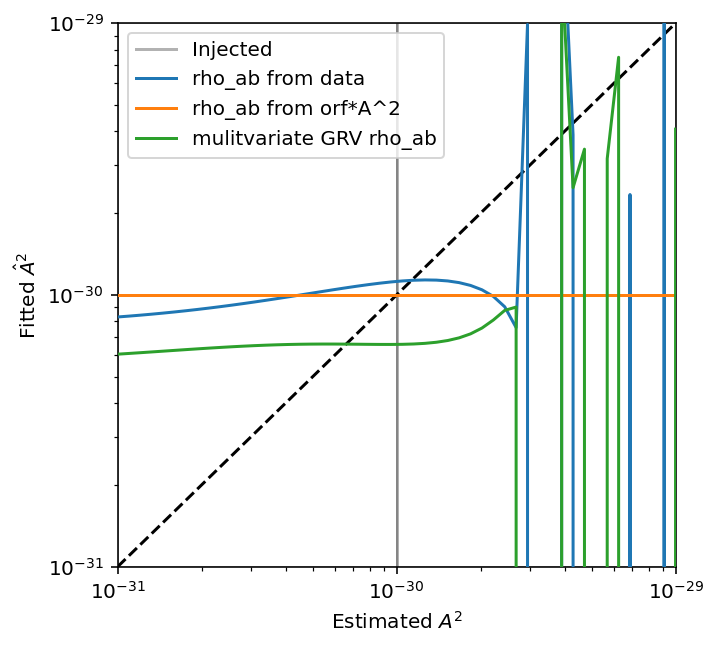

In [73]:
plt.figure(figsize=(5,5))
plt.plot(a2_est,a2_est,'--k')
plt.xlim([a2_est.min(),a2_est.max()])
plt.ylim([a2_est.min(),a2_est.max()])
plt.loglog()
plt.grid()
plt.axvline(inj_a2,color='k',label='Injected',alpha=0.3)
plt.axhline(inj_a2,color='k',alpha=0.3)
plt.xlabel('Estimated $A^2$')
plt.ylabel('Fitted $\hat{A}^2$')


plt.plot(a2_est,rho_data,'-C0',zorder=10,label='rho_ab from data')
plt.plot(a2_est,rho_true,'-C1',zorder=10,label='rho_ab from orf*A^2')
plt.plot(a2_est,rho_rand,'-C2',zorder=10,label='mulitvariate GRV rho_ab')
#plt.plot(a2_est,rho_scaled,'-C3',zorder=10,label='covariance scaled GRV rho_ab')

plt.legend()
plt.show()


### Updating X and Z values for each A^2

In [74]:
a2_est = 10**(2*np.linspace(-15.5,-14.5,50))
rho_update = []

from tqdm import tqdm
for a in tqdm(a2_est):
    pars = {}
    pars.update(inj_params)
    pars['gw_log10_A'] = np.log10(a)/2
    a2,a2s = OS_obj.compute_OS(pars,return_pair_vals=False,pair_covariance=True,use_tqdm=False)
    rho_update.append(a2)

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


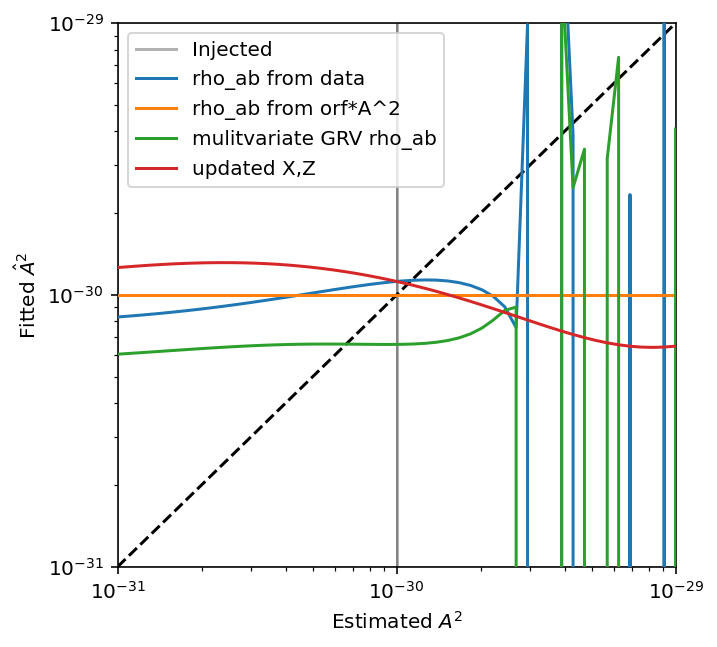

In [75]:
plt.figure(figsize=(5,5))
plt.plot(a2_est,a2_est,'--k')
plt.xlim([a2_est.min(),a2_est.max()])
plt.ylim([a2_est.min(),a2_est.max()])
plt.loglog()
plt.grid()
plt.axvline(inj_a2,color='k',label='Injected',alpha=0.3)
plt.axhline(inj_a2,color='k',alpha=0.3)
plt.xlabel('Estimated $A^2$')
plt.ylabel('Fitted $\hat{A}^2$')


plt.plot(a2_est,rho_data,'-C0',zorder=10,label='rho_ab from data')
plt.plot(a2_est,rho_true,'-C1',zorder=10,label='rho_ab from orf*A^2')
plt.plot(a2_est,rho_rand,'-C2',zorder=10,label='mulitvariate GRV rho_ab')
plt.plot(a2_est,rho_update,'-C3',zorder=10,label='updated X,Z')

plt.legend()
plt.show()


### Try this with intrinsic red noise

In [76]:
psrs,inj_params = mdc1_utils.create_MDC1_like_psrs(gwb_amplitude=1e-15,seed=10384,toaerr=0.1,
                                                   irn_amplitude=1e-15,irn_gamma=13./3.,irn_components=30)

pta = mdc1_utils.create_MDC1_PTA(psrs,include_irn=True,use_marginalizingtm=False)

OS_obj = OptimalStatistic(psrs,pta,'gw')

a2,a2s = OS_obj.compute_OS(inj_params,return_pair_vals=False,pair_covariance=False)
print(a2/a2s)

0.9780332907926582


In [77]:
a2_est = 10**(2*np.linspace(-15.5,-14.5,50))
rho_rn_update = []

from tqdm import tqdm
for a in tqdm(a2_est):
    pars = {}
    pars.update(inj_params)
    pars['gw_log10_A'] = np.log10(a)/2
    a2,a2s = OS_obj.compute_OS(pars,return_pair_vals=False,pair_covariance=True,use_tqdm=False)
    rho_rn_update.append(a2)

100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


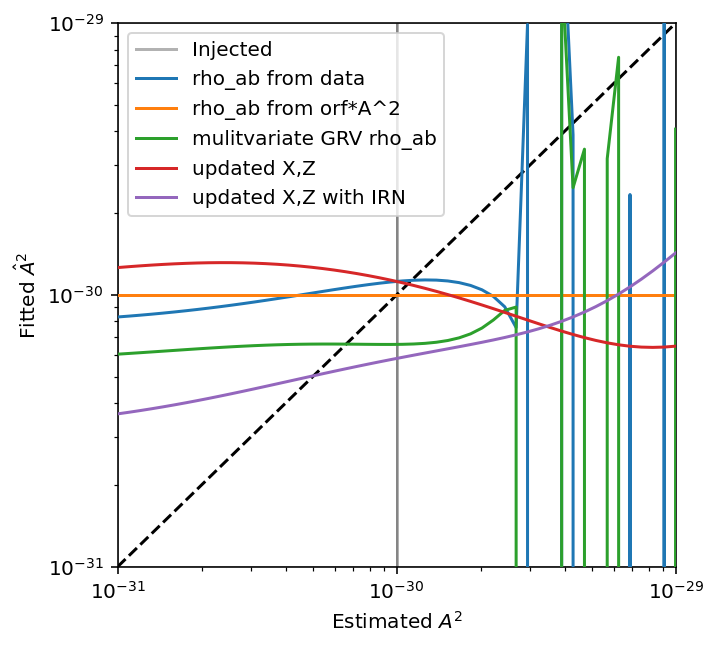

In [79]:
plt.figure(figsize=(5,5))
plt.plot(a2_est,a2_est,'--k')
plt.xlim([a2_est.min(),a2_est.max()])
plt.ylim([a2_est.min(),a2_est.max()])
plt.loglog()
plt.grid()
plt.axvline(inj_a2,color='k',label='Injected',alpha=0.3)
plt.axhline(inj_a2,color='k',alpha=0.3)
plt.xlabel('Estimated $A^2$')
plt.ylabel('Fitted $\hat{A}^2$')


plt.plot(a2_est,rho_data,'-C0',zorder=10,label='rho_ab from data')
plt.plot(a2_est,rho_true,'-C1',zorder=10,label='rho_ab from orf*A^2')
plt.plot(a2_est,rho_rand,'-C2',zorder=10,label='mulitvariate GRV rho_ab')
plt.plot(a2_est,rho_update,'-C3',zorder=10,label='updated X,Z')
plt.plot(a2_est,rho_rn_update,'-C4',zorder=10,label='updated X,Z with IRN')

plt.legend()
plt.show()
